<a href="https://colab.research.google.com/github/Victor1992/Bit_Predict_Regression/blob/main/bit_predict_time_series_forecasting_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series forecating funcdamentals with tensorflow : Bit Predict

## Importing time series data with pandas



In [1]:
import pandas as pd



In [2]:
df = pd.read_csv("/content/sample_data/BTC_USD_2014-11-04_2022-01-10-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2014-11-04,BTC,324.467934,323.826186,333.539527,323.106623
2014-11-05,BTC,328.644408,324.424164,330.671610,320.902900
2014-11-06,BTC,337.921358,328.653046,342.384170,328.597125
2014-11-07,BTC,348.992860,337.921358,352.585895,336.236830
2014-11-08,BTC,341.459753,348.992860,351.651854,340.196145


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2625 entries, 2014-11-04 to 2022-01-10
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2625 non-null   object 
 1   Closing Price (USD)  2625 non-null   float64
 2   24h Open (USD)       2625 non-null   float64
 3   24h High (USD)       2625 non-null   float64
 4   24h Low (USD)        2625 non-null   float64
dtypes: float64(4), object(1)
memory usage: 123.0+ KB


`Note: Numpy likes data in float64, tensprflow likes the data in float32`

In [4]:
# How many samples  do we have ?
len(df)

2625

In [5]:
8 * 365 # around 8 years of data we have

2920

In [6]:
# Only want closing price for each day

bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2014-11-04,324.467934
2014-11-05,328.644408
2014-11-06,337.921358
2014-11-07,348.992860
2014-11-08,341.459753


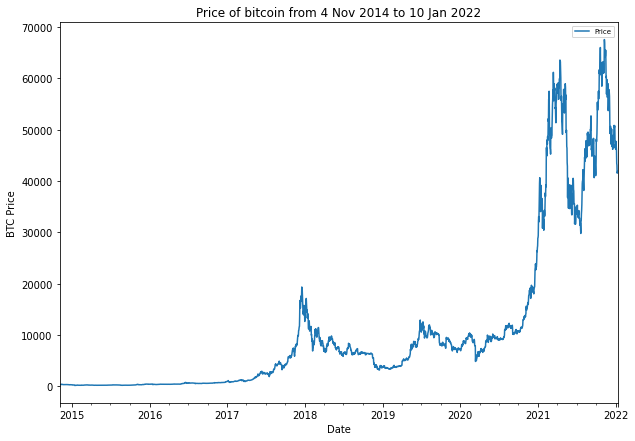

In [7]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of bitcoin from 4 Nov 2014 to 10 Jan 2022")
plt.legend(fontsize=7);

## Format data part 1: Create train and test sets of our time series data

### Creating train test splits the wrong way

In [8]:
timestamps  =bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()
timestamps[:10], prices[:10]

(array(['2014-11-04T00:00:00.000000000', '2014-11-05T00:00:00.000000000',
        '2014-11-06T00:00:00.000000000', '2014-11-07T00:00:00.000000000',
        '2014-11-08T00:00:00.000000000', '2014-11-09T00:00:00.000000000',
        '2014-11-10T00:00:00.000000000', '2014-11-11T00:00:00.000000000',
        '2014-11-12T00:00:00.000000000', '2014-11-13T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([324.467934, 328.644408, 337.921358, 348.99286 , 341.459753,
        344.745289, 357.239982, 371.116917, 366.664633, 428.882925]))

In [9]:
# Wrong way to make train/ test sets fro rime series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timestamps, #dates
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2100,), (525,), (2100,), (525,))

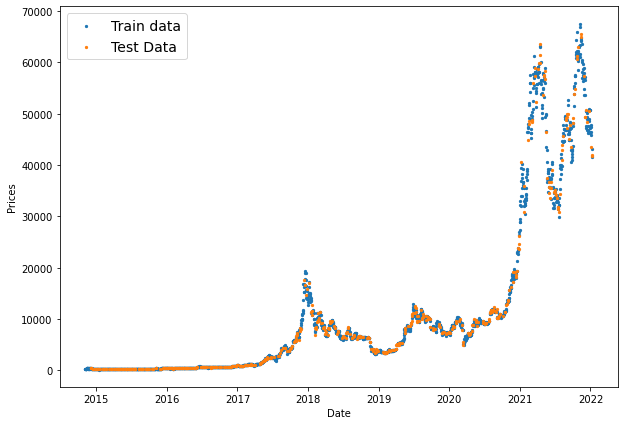

In [10]:
# Lest plot wrong train and test splits

plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train,s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test Data")
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend(fontsize=14)
plt.show()

`Why wrong -- as we can see there is a data lekage in splits`

### Creating the tarin/test splits for time series the correct way


In [11]:
split_size = int(0.8 * len(prices)) # * 80% train, 20% split

# Train data splits
X_train, y_train = timestamps[:split_size], prices[:split_size]

# Test data splits
X_test, y_test = timestamps[split_size:], prices[split_size:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2100,), (525,), (2100,), (525,))

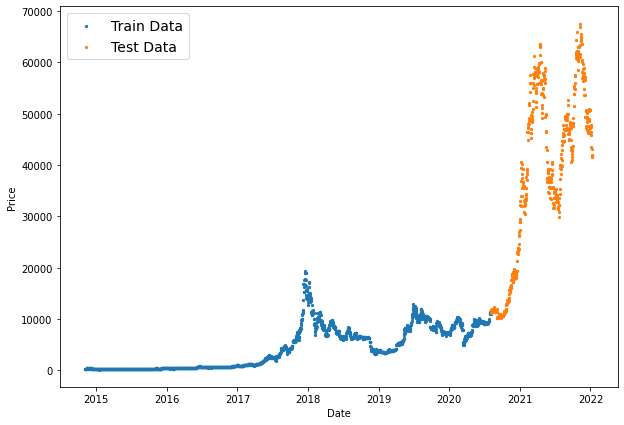

In [12]:
# Plot correctly made splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train,s=5, label="Train Data")
plt.scatter(X_test, y_test,s=5, label="Test Data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(fontsize=14)
plt.show();

## Create a plotting function

In [13]:
def plot_time_series(timestamps, values, format=".", start=0, end=None, label=None):
  """
  Plots timestamps against values

  Parameters
  ----------
  timestamps : array of timestamp values
  values : array of values across time
  format : style of plot, default="."
  start : where to start the plot
  end : where to end the plot
  label : label to show on plot about values, default None
  """

  plt.plot(timestamps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

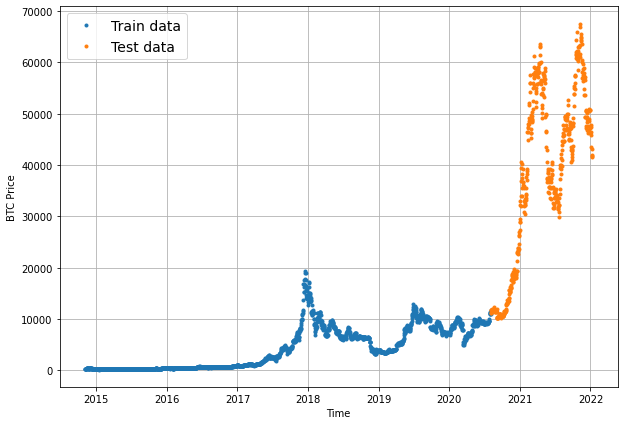

In [14]:
plt.figure(figsize=(10,7))
plot_time_series(timestamps=X_train, values=y_train, label="Train data")
plot_time_series(timestamps=X_test, values=y_test, label="Test data")

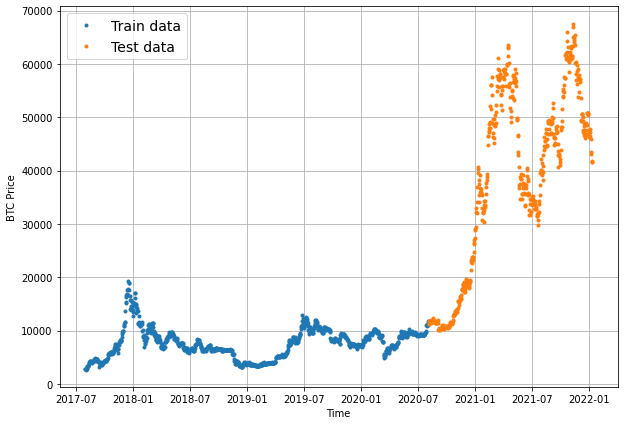

In [15]:
plt.figure(figsize=(10,7))
plot_time_series(timestamps=X_train, values=y_train, start=1000,label="Train data") # Zooming the data
plot_time_series(timestamps=X_test, values=y_test, label="Test data")

## Modelling Experiments

* Horizon = number of timestamps into the future we're going to predict
* Window Size = number od timestamps we're going to use to predict horizon

## 1 Naive Model(Baseline)

formula:

$$\hat{y}_{t} = y_{t-1}$$

> The prediction at timestep t(y-hat) is equal to the value at timestep t-1 (previous timestep) -  for horizon of 1

https://otexts.com/fpp3/simple-methods.html

In [16]:
y_test[:10]

array([11237.354858, 11194.363266, 11752.296549, 11773.533625,
       11604.023443, 11772.251532, 11688.53133 , 11895.310159,
       11391.014647, 11569.186093])

In [17]:
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([11237.354858, 11194.363266, 11752.296549, 11773.533625,
        11604.023443, 11772.251532, 11688.53133 , 11895.310159,
        11391.014647, 11569.186093]),
 array([47128.468155, 46208.210437, 47739.420026, 47317.947964,
        46434.508081, 45837.130344, 43428.699545, 43107.257821,
        41534.350712, 41687.227593]))

In [18]:
y_test[-10:]

array([46208.210437, 47739.420026, 47317.947964, 46434.508081,
       45837.130344, 43428.699545, 43107.257821, 41534.350712,
       41687.227593, 41861.803632])

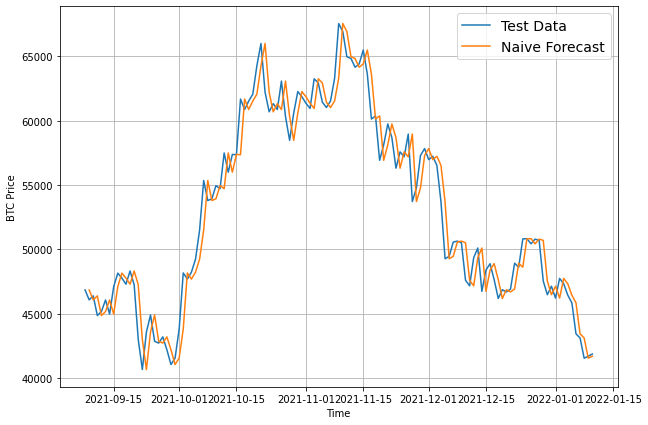

In [19]:
# Plot Naive forecast
plt.figure(figsize=(10,7))
# plot_time_series(timestamps=X_train, values=y_train, label="Train Data")
plot_time_series(timestamps=X_test, values=y_test, start=400, format="-",label="Test Data")
plot_time_series(timestamps=X_test[1:], values=naive_forecast,start=400, format="-",label="Naive Forecast")

#### Evaluating time series model 

How good our model's forecast y_pred compare aginst the actual values(y_true or ground truth values) ?

Common regression metrics:

* MAE -  mean absolute error
* MSE - mean squared error
* RMSE -  root mean square error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error


In [20]:
import tensorflow as tf

def evaluate_preds(y_true, y_pred):

  mae= tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

  # Account for different sized metrics( for longer version, we want to reduce to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse =tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape= tf.reduce_mean(mape)
    
  return {
      "mae": mae.numpy(),
      "mse": mse.numpy(),
      "rmse": rmse.numpy(),
      "mape": mape.numpy()
  } 

In [21]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 1112.547989736641,
 'mape': 2.822934133016182,
 'mse': 2676604.3201613766,
 'rmse': 1636.0331048488526}

## Format data part 2: Windowing our dataset

We window our time series to turn data into a supervised learning problem

```
Windowing for 1 week
[0,1,2,3,4,5,6]->[7]


In [22]:
# What we want to do with our bitcoin data
print(f"We want to use: {prices[:7]} to predict: {prices[7]}")


We want to use: [324.467934 328.644408 337.921358 348.99286  341.459753 344.745289
 357.239982] to predict: 371.116917


In [23]:
# Global variables for window anfd horizon size
HORIZON  = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of bitcoin data to make teh prediction

In [24]:
# Function to label windowed data
def get_labeled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> ouput: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [25]:
test_window, test_label = get_labeled_windows(tf.expand_dims(tf.range(8), axis=0))
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5, 6]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[7]], dtype=int32)>)

We have got a way to label our windowed data.

However, this works only for a small scale.

Now we need to do tit for entire time series

We could do this with python loops, however for large time seires, that'd be quite slow.

To speed things up, we will leverage NUmPy's indexing. https://numpy.org/doc/stable/user/basics.indexing.html

**Resource: The fucntion we are about to create has been adapted from the following article**

https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [26]:
import numpy as np

def make_windows(x, window_size=WINDOW_SIZE, horizon = HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # Create 
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T

  windowed_array = x[window_indexes]

  windows, labels = get_labeled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [27]:
 window_step=np.expand_dims(np.arange(8), axis=0)
 window_indexes = window_step + np.expand_dims(np.arange(len(prices)-(8-1)), axis=0).T
windowed_array = prices[window_indexes]
windowed_array

array([[  324.467934,   328.644408,   337.921358, ...,   344.745289,
          357.239982,   371.116917],
       [  328.644408,   337.921358,   348.99286 , ...,   357.239982,
          371.116917,   366.664633],
       [  337.921358,   348.99286 ,   341.459753, ...,   371.116917,
          366.664633,   428.882925],
       ...,
       [46208.210437, 47739.420026, 47317.947964, ..., 43428.699545,
        43107.257821, 41534.350712],
       [47739.420026, 47317.947964, 46434.508081, ..., 43107.257821,
        41534.350712, 41687.227593],
       [47317.947964, 46434.508081, 45837.130344, ..., 41534.350712,
        41687.227593, 41861.803632]])

In [28]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
full_windows[:10], full_labels[:10]

(array([[324.467934, 328.644408, 337.921358, 348.99286 , 341.459753,
         344.745289, 357.239982],
        [328.644408, 337.921358, 348.99286 , 341.459753, 344.745289,
         357.239982, 371.116917],
        [337.921358, 348.99286 , 341.459753, 344.745289, 357.239982,
         371.116917, 366.664633],
        [348.99286 , 341.459753, 344.745289, 357.239982, 371.116917,
         366.664633, 428.882925],
        [341.459753, 344.745289, 357.239982, 371.116917, 366.664633,
         428.882925, 418.944218],
        [344.745289, 357.239982, 371.116917, 366.664633, 428.882925,
         418.944218, 399.688315],
        [357.239982, 371.116917, 366.664633, 428.882925, 418.944218,
         399.688315, 374.983975],
        [371.116917, 366.664633, 428.882925, 418.944218, 399.688315,
         374.983975, 388.040069],
        [366.664633, 428.882925, 418.944218, 399.688315, 374.983975,
         388.040069, 387.062731],
        [428.882925, 418.944218, 399.688315, 374.983975, 388.040069,
    

In [29]:
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [324.467934 328.644408 337.921358 348.99286  341.459753 344.745289
 357.239982] -> Label: [371.116917]
Window: [328.644408 337.921358 348.99286  341.459753 344.745289 357.239982
 371.116917] -> Label: [366.664633]
Window: [337.921358 348.99286  341.459753 344.745289 357.239982 371.116917
 366.664633] -> Label: [428.882925]


In [30]:
len(full_windows), len(full_labels)

(2618, 2618)

In [31]:
len(prices)


2625

## Turning our windowed time series data into trainiing and test splits

In [32]:
# Make train and test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits
  """
  split_size = int(len(windows) * (1-test_split)) # This will default to 80% test/ 20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels 


In [33]:
train_windows, test_windows, train_labels, test_labels =  make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2094, 524, 2094, 524)

In [34]:
# Check to see if train labels are the same( before and after window split)

np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

False

In [35]:
test_labels.shape


(524, 1)

In [36]:
len(y_train)

2100

In [37]:
len(train_labels)

2094

In [38]:
-HORIZON-1

-2

In [39]:
len(np.squeeze(train_labels[:-HORIZON-1]))

2092

In [40]:
train_labels[2093]

array([11237.354858])

In [41]:
y_train[-10:]

array([ 9551.22437 ,  9710.2     ,  9940.53292 , 11045.5     ,
       10933.5     , 11110.779249, 11112.39206 , 11351.67    ,
       11816.057687, 11065.305792])

In [42]:
y_train[2093]

11045.5

## Making a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint.

More specifially, we want to compare each of our's model's best performances against the other model's best performances.

For example if our model performs best on epoch 55(but we are training for 100 epochs), we want to load anf evaluate the model saved on epoch 55


In [43]:
import os

# Function to implement a model checkpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

## Model 1: Dense model

Our first deep model will is going to be a simple dense model:
* A single dense layer with 120 hidden unitsand ReLU
* An output layer with linear activation
* Adam optimization and MAE loss funcion
* Batch size of 128 (as we have less data we can afford large batch size)
* 100 epochs

In [44]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for reproducible results
tf.random.set_seed(42)

# 1. Constrcut model
model_1 = tf.keras.Sequential([
                               layers.Dense(128, activation="relu"),
                               layers.Dense(HORIZON, activation="linear") # Linear activaton is samea shaving no activation
], name="model_1_dense")

# 2. Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])


Epoch 1/100
66/66 [==============================] - 1s 12ms/step - loss: 471.7239 - mae: 471.7239 - mse: 1071527.1250 - val_loss: 1912.5199 - val_mae: 1912.5199 - val_mse: 6727698.0000
Epoch 2/100
66/66 [==============================] - 1s 9ms/step - loss: 220.1906 - mae: 220.1906 - mse: 189433.1562 - val_loss: 1893.0193 - val_mae: 1893.0193 - val_mse: 6341999.0000
Epoch 3/100
66/66 [==============================] - 1s 8ms/step - loss: 206.4901 - mae: 206.4901 - mse: 165161.4688 - val_loss: 1633.6552 - val_mae: 1633.6552 - val_mse: 5448373.0000
Epoch 4/100
66/66 [==============================] - 1s 9ms/step - loss: 184.5336 - mae: 184.5336 - mse: 139346.7812 - val_loss: 1417.8542 - val_mae: 1417.8542 - val_mse: 3970561.0000
Epoch 5/100
66/66 [==============================] - 1s 8ms/step - loss: 174.2422 - mae: 174.2422 - mse: 124638.1094 - val_loss: 1386.0103 - val_mae: 1386.0103 - val_mse: 3941557.2500
Epoch 6/100
66/66 [==============================] - 1s 9ms/step - loss: 167.6

In [45]:
# evaluate model on test data
model_1.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 1ms/step - loss: 1116.9980 - mae: 1116.9980 - mse: 2676970.7500


[1116.998046875, 1116.998046875, 2676970.75]

MSE is usally a lot higher than MAE because it has got the squaring factor in there that is square the errors

In [46]:
# Load in the best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("/content/model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 1ms/step - loss: 1116.3684 - mae: 1116.3684 - mse: 2675905.0000


[1116.368408203125, 1116.368408203125, 2675905.0]

## Making forecast with a model(on the test dataset)

Steps:

1. Take a train model
2. Takes in some input data(same kind of data the model is trained on)
3. Passes the input data to model's `predict()` method
4. Returns the predictions

In [47]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # retyrn 1d array of predictions

In [48]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(524, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([11197.032, 11201.688, 11705.156, 11762.62 , 11651.484, 11751.153,
        11723.065, 11867.334, 11442.38 , 11539.958], dtype=float32)>)

In [49]:
# evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 1116.3685, 'mape': 2.8272014, 'mse': 2675905.0, 'rmse': 1635.8193}

In [50]:
naive_results

{'mae': 1112.547989736641,
 'mape': 2.822934133016182,
 'mse': 2676604.3201613766,
 'rmse': 1636.0331048488526}

In [51]:
model_1_preds.shape

TensorShape([524])

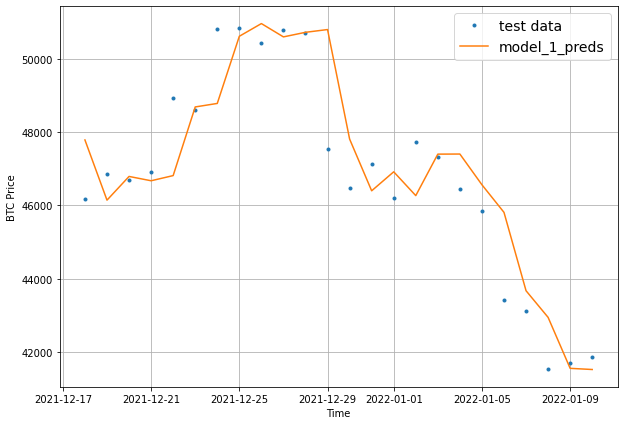

In [52]:
# Lets plot model 1 prediction
offset=500
plt.figure(figsize=(10,7))
plot_time_series(timestamps=X_test[-len(test_windows):],
                 values=test_labels[:,0],
                 start=offset,
                 label="test data")

plot_time_series(timestamps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset,
                 format="-",
                 label="model_1_preds")

## Model 2: Dense(window=30, horizon=1)

In [53]:
HORIZON = 1 # Predict one step at a time
WINDOW_SIZE = 30 # use 30 timestamps in past


In [54]:
# Make windows data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2595, 2595)

In [55]:
# make train test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2076, 519, 2076, 519)

In [56]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
                               layers.Dense(128, activation="relu"),
                               layers.Dense(HORIZON),
], name="model_2_dense")

# Compile
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: mod

In [57]:
model_2.evaluate(test_windows, test_labels )

17/17 [==============================] - 0s 1ms/step - loss: 1194.7294


1194.7293701171875

In [58]:
# Load and evaluate on best performing model
model_2 = tf.keras.models.load_model("/content/model_experiments/model_2_dense")
model_2.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 1ms/step - loss: 1191.1052


1191.105224609375

In [59]:
# Make predictions
model_2_preds = make_preds(model_2, test_windows)


In [60]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 1191.1051, 'mape': 3.003334, 'mse': 2955999.0, 'rmse': 1719.3019}

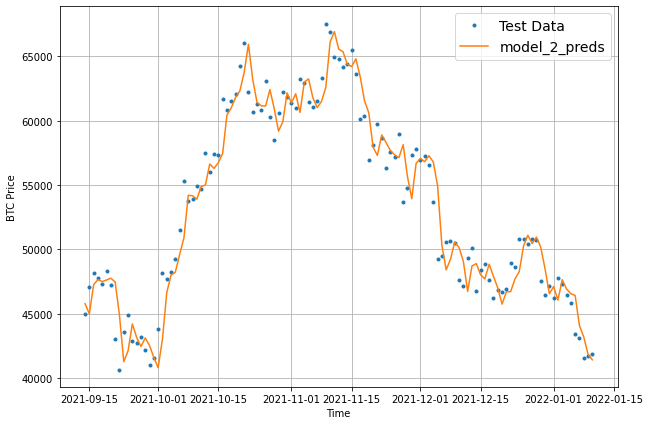

In [61]:
offset= 400
plt.figure(figsize=(10,7))
plot_time_series(timestamps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test Data")
plot_time_series(timestamps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3: Dense(window=30, horizon=7)

In [62]:
HORIZON = 7 # predict 7 steps at a time
WINDOW = 30 # Use 30 tiemstamps in past

In [63]:
# Make windows data with appropriate horison and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2589, 2589)

In [64]:
# Train test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels,0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2071, 518, 2071, 518)

In [65]:
tf.random.set_seed(42)

# Create model
model_3 = tf.keras.Sequential([
         layers.Dense(128,activation="relu"),
         layers.Dense(HORIZON)            
], name="model_3_dense")

# Compile
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_3.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128, 
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: mod

In [66]:
model_3.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 1ms/step - loss: 2404.2107


2404.210693359375

In [67]:
# Loading and evaluation the best model
model_3 = tf.keras.models.load_model("/content/model_experiments/model_3_dense")
model_3.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 1ms/step - loss: 2358.1794


2358.179443359375

In [68]:
# predictions
model_3_preds = make_preds(model_3,test_windows)

In [69]:
(tf.squeeze(test_labels)).shape, (tf.squeeze(model_3_preds)).shape

(TensorShape([518, 7]), TensorShape([518, 7]))

In [70]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),y_pred= tf.squeeze(model_3_preds))
model_3_results

{'mae': 2358.1794, 'mape': 5.9577384, 'mse': 11636976.0, 'rmse': 2703.2874}

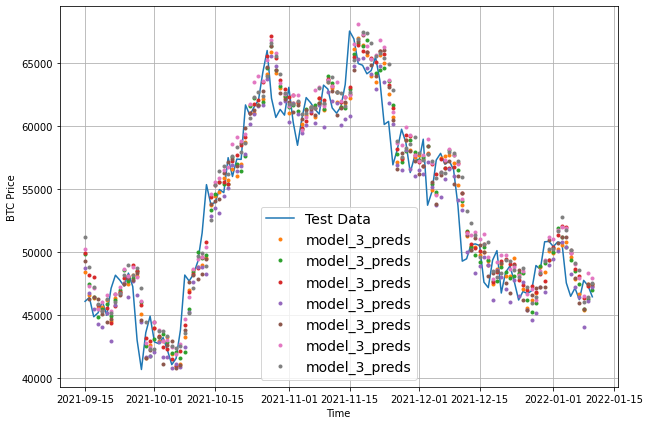

In [71]:
# Plot to compare the results
offset = 400
plt.figure(figsize=(10,7))

plot_time_series(timestamps=X_test[-len(test_windows):], values=test_labels[:,0], format="-",start=offset, label="Test Data")
plot_time_series(timestamps=X_test[-len(test_windows):], values=model_3_preds, start=offset,  label="model_3_preds")

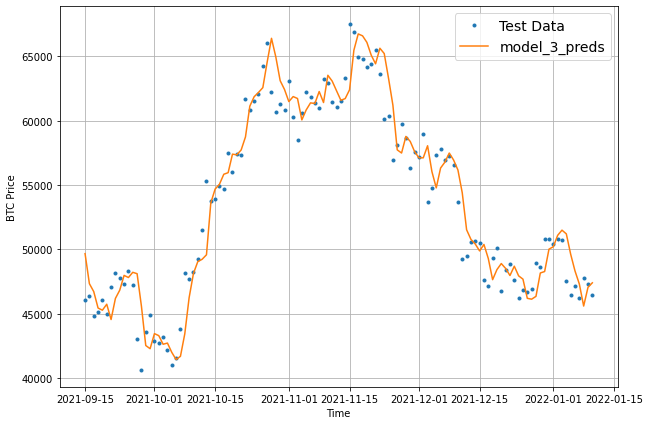

In [72]:
offset = 400
plt.figure(figsize=(10,7))

plot_time_series(timestamps=X_test[-len(test_windows):], values=test_labels[:,0],start=offset, label="Test Data")
plot_time_series(timestamps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), format="-",start=offset,  label="model_3_preds")

## Which of our models is performing the best so far ?


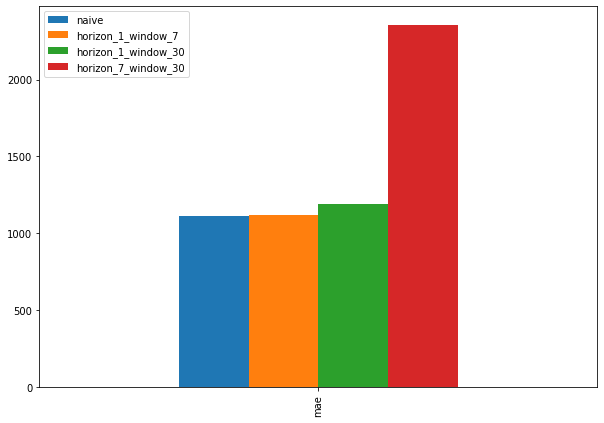

In [73]:
pd.DataFrame({"naive": naive_results,
              "horizon_1_window_7": model_1_results,
              "horizon_1_window_30": model_2_results,
              "horizon_7_window_30": model_3_results}, index=["mae"]).plot(figsize=(10,7), kind="bar");

## Model 4: Conv1D

In [74]:
HORIZON = 1 # predict nect day of bitcoin prices
WINDOW_SIZE = 7 # use previous week worth data


In [75]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON )
len(full_windows), len(full_labels)

(2618, 2618)

In [76]:
# Create train and test sets 
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, 
                                                                                full_labels,
                                                                                test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2094, 524, 2094, 524)